In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal


recgym = pd.read_csv('/kaggle/input/10-gym-exercises-with-615-abstracted-features/RecGym.csv')
recgym

,Subject,Position,Session,A_x,A_y,A_z,G_x,G_y,G_z,C_1,Workout
0,1,wrist,1,0.501125,0.500625,0.500500,0.500156,0.499962,0.500313,0.501227,Null
1,1,wrist,1,0.500250,0.499750,0.501250,0.499531,0.500550,0.500081,0.501584,Null
2,1,wrist,1,0.500250,0.499375,0.501875,0.499613,0.500231,0.500119,0.501508,Null
3,1,wrist,1,0.499625,0.499750,0.500875,0.499494,0.500350,0.500588,0.502032,Null
4,1,wrist,1,0.500000,0.499000,0.501000,0.499650,0.500588,0.499769,0.501756,Null
...,...,...,...,...,...,...,...,...,...,...,...
4703315,10,pocket,5,0.492375,0.511000,0.430250,0.499494,0.327656,0.557150,0.455056,Null
4703316,10,pocket,5,0.582000,0.443375,0.398750,0.562931,0.495744,0.546406,0.476527,Null
4703317,10,pocket,5,0.627750,0.514250,0.467375,0.485037,0.450975,0.553125,0.501798,Null
4703318,10,pocket,5,0.589625,0.509500,0.479125,0.427306,0.529181,0.453050,0.502269,Null


In [2]:
recgym['Position'].unique()

array(['wrist', 'leg', 'pocket'], dtype=object)

# Data

Dataset contains recordings at 20Hz for x,y,z for accelerometer and gyroscope with addition to human body capacitance device mentioned in the paper. The data is equally from pocket, leg and wrist sensors. Half of the data is unlabeled, supposedly for furniture moving exercise also mentioned in the paper

In [3]:
lbl_gym = recgym[recgym['Workout'] != 'Null']
lbl_gym

,Subject,Position,Session,A_x,A_y,A_z,G_x,G_y,G_z,C_1,Workout
476,1,wrist,1,0.499875,0.500375,0.501500,0.499337,0.500550,0.499725,0.501602,LegCurl
477,1,wrist,1,0.503000,0.498250,0.501000,0.500194,0.500663,0.499919,0.501452,LegCurl
478,1,wrist,1,0.498500,0.501250,0.500750,0.497069,0.501794,0.499569,0.501369,LegCurl
479,1,wrist,1,0.499750,0.499625,0.501125,0.498787,0.501444,0.499688,0.501086,LegCurl
480,1,wrist,1,0.498625,0.498625,0.502375,0.498244,0.501094,0.499806,0.501045,LegCurl
...,...,...,...,...,...,...,...,...,...,...,...
4702863,10,pocket,5,0.470250,0.512500,0.472500,0.506800,0.490312,0.519450,0.502216,Riding
4702864,10,pocket,5,0.468250,0.506375,0.484875,0.498831,0.491563,0.524613,0.502403,Riding
4702865,10,pocket,5,0.466875,0.503125,0.477250,0.506250,0.476406,0.533362,0.502056,Riding
4702866,10,pocket,5,0.500375,0.550500,0.510250,0.521525,0.494063,0.473825,0.495943,Riding


In [4]:
lbl_gym['Workout'].unique()

array(['LegCurl', 'Squat', 'Adductor', 'LegPress', 'ArmCurl',
       'BenchPress', 'RopeSkipping', 'Walking', 'Running', 'StairClimber',
       'Riding'], dtype=object)

In [5]:
def plot_exercise(subject, workout, session):
    exercise = lbl_gym[(lbl_gym['Subject'] == subject) & (lbl_gym['Session'] == session) 
                      & (lbl_gym['Workout'] == workout) ]

    cols_to_plot = ['A_x', 'A_y', 'A_z', 'G_x', 'G_y', 'G_z', 'C_1']
    
    fig, axes = plt.subplots(nrows=len(cols_to_plot), ncols=1, figsize=(10, 10), sharex=True)
    
    for i, col in enumerate(cols_to_plot):
        lbl_gym.groupby('Position')[col].plot(ax=axes[i], legend=True)
        
        axes[i].set_title(f"Metric: {col}")
        axes[i].set_ylabel("Value")
    
    plt.tight_layout()
    plt.show()

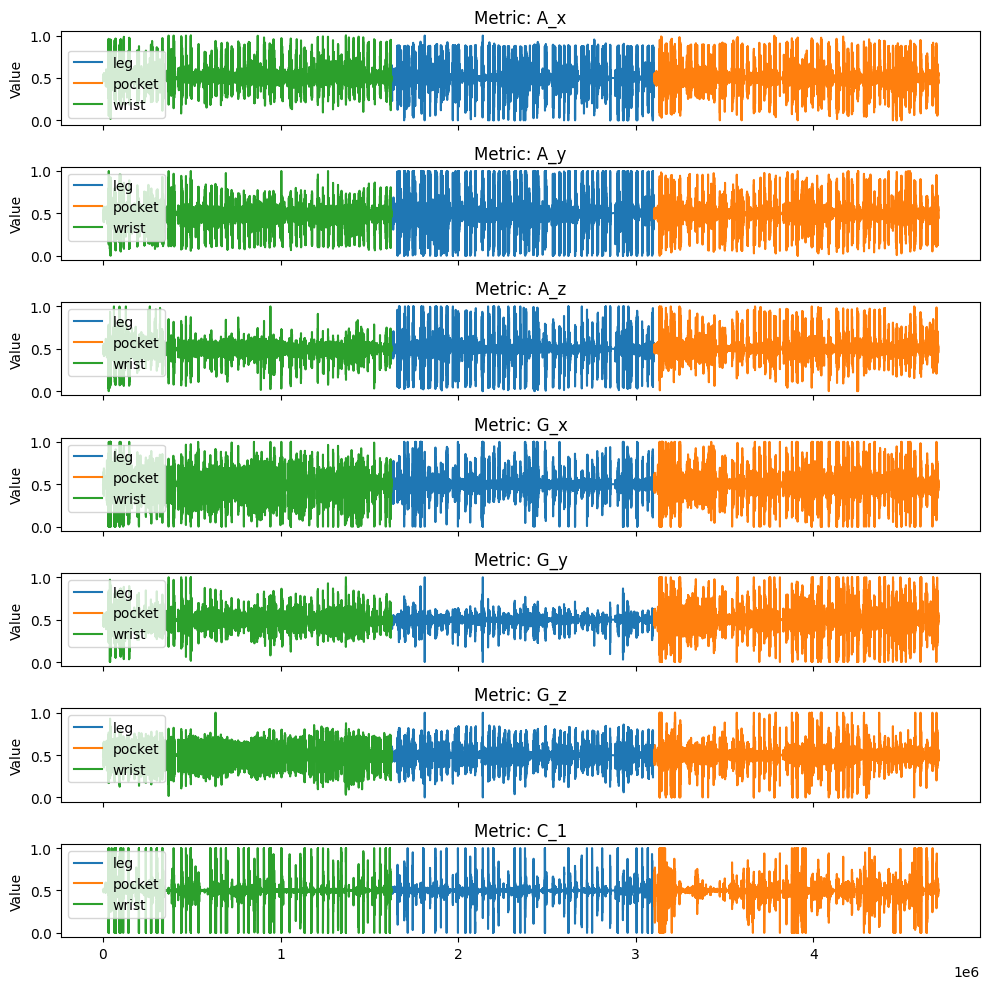

In [6]:
plot_exercise(1, 'LegCurl', 1)

Like this we can plot oscillations for each exercise. They should have distinct features. We could use two approaches for classification. Either hand pick unique patterns in oscillations and measure how much of they appear in each recording. Or the second way (this way) decompose signals with Fast Fourier Transform or Wavelets. Waveletes are better because they record also temporal relations in data

In [7]:
def spectrogram_plot(subject1, session1, workout1, subject2, session2, workout2):
    fs = 20
    num_signals = 7

    fig, axes = plt.subplots(nrows=num_signals, ncols=2, figsize=(10, 15), sharex=False)

    exercise1 = lbl_gym[(lbl_gym['Subject'] == subject1) & (lbl_gym['Session'] == session1) 
                      & (lbl_gym['Workout'] == workout1) & (lbl_gym['Position'] == 'wrist') ]

    exercise2 = lbl_gym[(lbl_gym['Subject'] == subject2) & (lbl_gym['Session'] == session2) 
                      & (lbl_gym['Workout'] == workout2) & (lbl_gym['Position'] == 'wrist')]

    
    cols_to_plot = ['A_x', 'A_y', 'A_z', 'G_x', 'G_y', 'G_z', 'C_1']    
    
    for i in range(num_signals):
        # f = array of sample frequencies
        # t = array of segment times
        # Sxx = spectrogram of x (the 2D heatmap data)
        f1, t1, Sxx1 = signal.spectrogram(
            exercise1[cols_to_plot[i]], 
            fs=fs, 
            nperseg=256,    
            noverlap=128, 
        )

        f2, t2, Sxx2 = signal.spectrogram(
            exercise2[cols_to_plot[i]], 
            fs=fs, 
            nperseg=256,    
            noverlap=128, 
        )
        
        img1 = axes[i, 0].pcolormesh(t1, f1, -10 * np.log10(Sxx1), shading='gouraud', cmap='inferno')
        img2 = axes[i, 1].pcolormesh(t2, f2, -10 * np.log10(Sxx2), shading='gouraud', cmap='inferno')
        
        
        axes[i, 0].set_ylabel('Freq [Hz]')
        axes[i, 0].set_title(f'Signal {cols_to_plot[i]}')

        axes[i, 1].set_ylabel('Freq [Hz]')
        axes[i, 1].set_title(f'Signal {cols_to_plot[i]}')
        
        
        fig.colorbar(img1, ax=axes[i, 0], label='Power [dB]')
        fig.colorbar(img2, ax=axes[i, 1], label='Power [dB]')
    
    
    axes[-1, 0].set_xlabel('Time [sec]')
    axes[-1, 1].set_xlabel('Time [sec]')
    
    plt.ylim([0.1, 10])
    plt.tight_layout()
plt.show()

The spectogram is more unique in original version and more "painted" when we take log of the spectrography. By taking the log (which is not applied here) we will see also contributions from less noticable osciallations. We can also combine idividual components to single picture (also not done here). Each picture should be unique for individual exercise. However exercises by different people are offset in time which would confuse Convolutional Method. So this convinced me to use Wavelets with Random Forrest for classification and concentrate more on frequency domain.

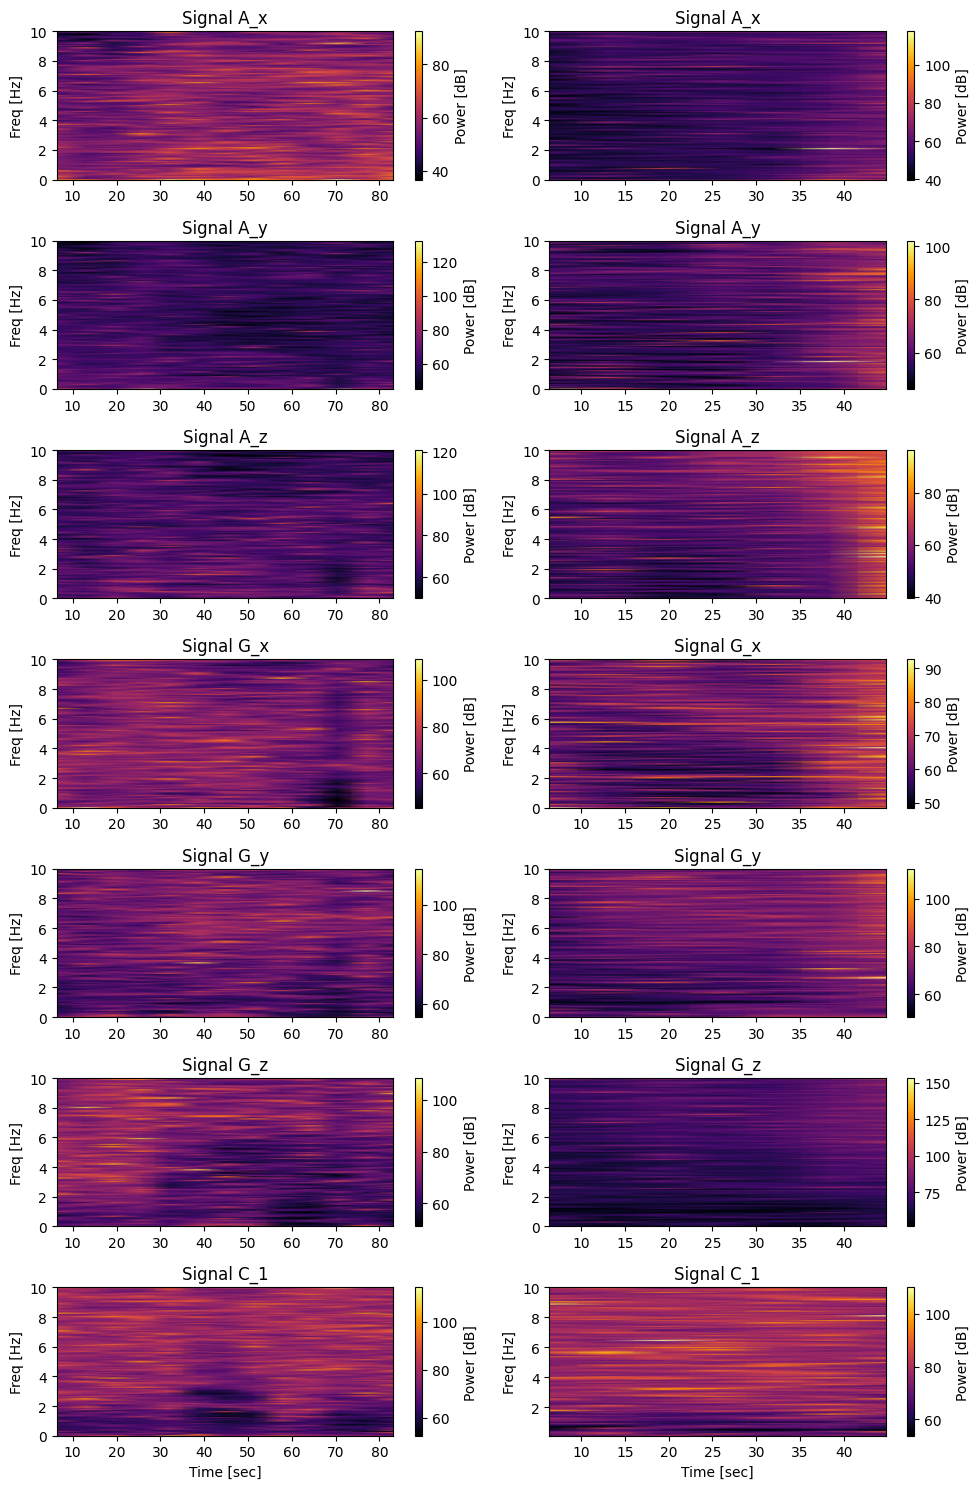

In [8]:
spectrogram_plot(1, 1, 'LegCurl', 2, 1, 'LegCurl')

The images show single exercise with one subject on the left and the other on the right. The conclusion following is that time domain although helpful is not as important for this problem as decomposition to frequency bands.

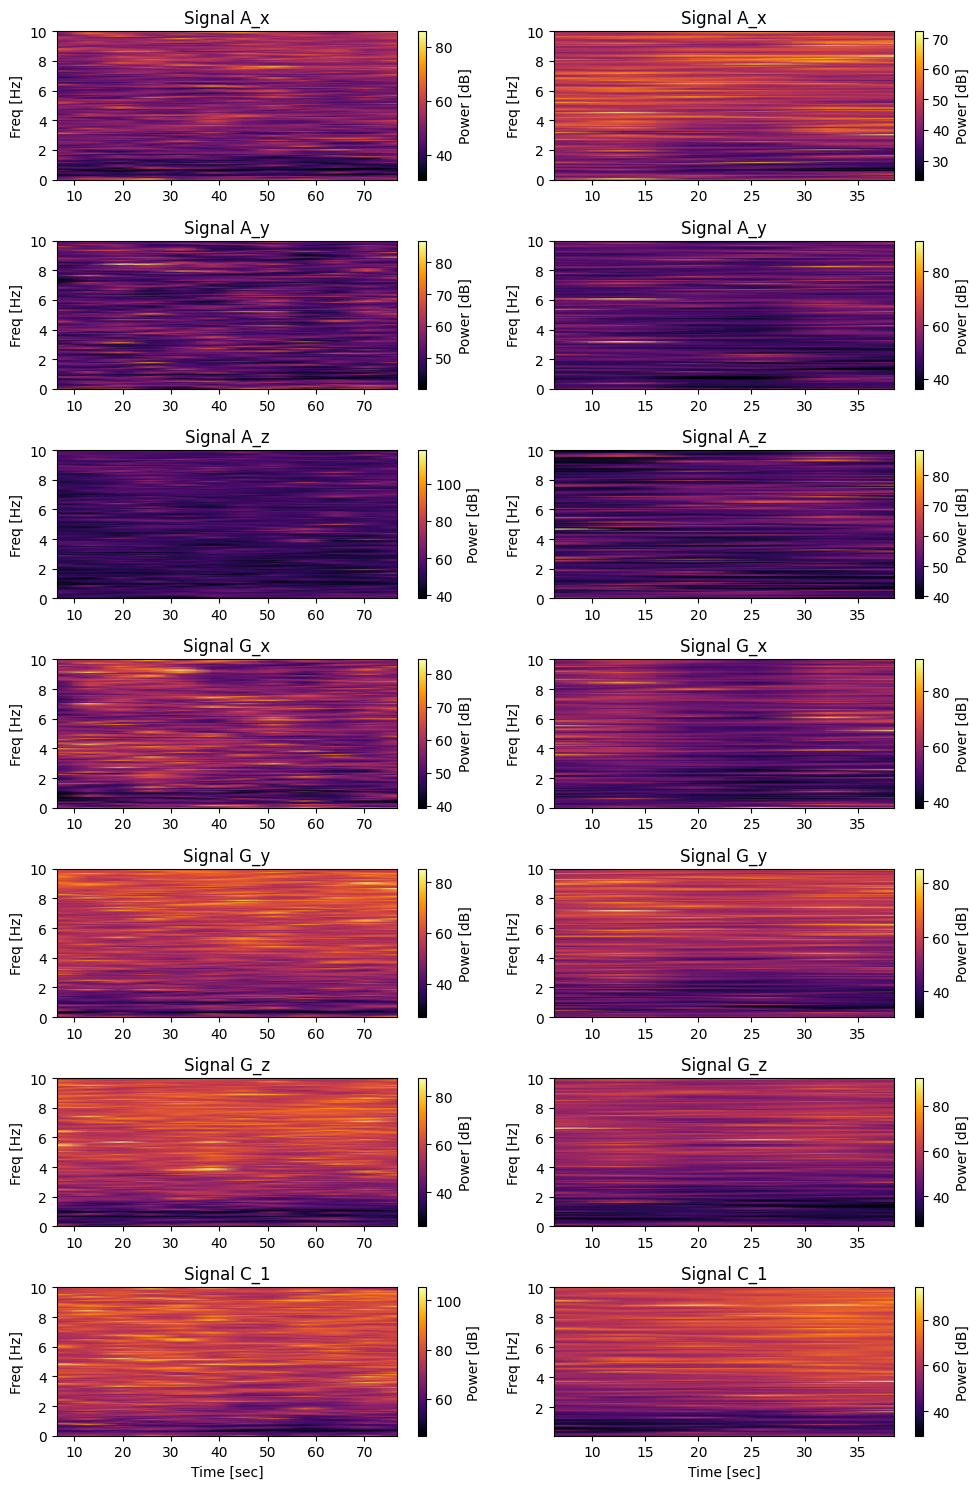

In [9]:
spectrogram_plot(1, 1, 'BenchPress', 1, 2, 'BenchPress')

Images show bench press exercise for one person on the left for first session on the right to second session. Spectrograms differ also for the same person with different durations.

In [10]:
from scipy import signal

def periodogram_plot(subject1, session1, workout1, subject2, session2, workout2, device):
    fs = 20
    num_signals = 7

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 15), sharex=False)

    exercise1 = lbl_gym[(lbl_gym['Subject'] == subject1) & (lbl_gym['Session'] == session1) 
                      & (lbl_gym['Workout'] == workout1) & (lbl_gym['Position'] == 'wrist') ]

    exercise2 = lbl_gym[(lbl_gym['Subject'] == subject2) & (lbl_gym['Session'] == session2) 
                      & (lbl_gym['Workout'] == workout2) & (lbl_gym['Position'] == 'wrist')]

    
    cols_to_plot = {'acc': ['A_x', 'A_y', 'A_z'], 
                    'gyro': ['G_x', 'G_y', 'G_z']}

    if device != 'acc' and device != 'gyro':
        return

        
    f1, Psd1 = signal.welch(
        exercise1[cols_to_plot[device][0]], 
        fs=fs 
    )

    f2, Psd2 = signal.welch(
        exercise2[cols_to_plot[device][0]], 
        fs=fs
    )

    f11, Psd11 = signal.welch(
        exercise1[cols_to_plot[device][1]], 
        fs=fs 
    )

    f22, Psd22 = signal.welch(
        exercise2[cols_to_plot[device][1]], 
        fs=fs
    )

    f111, Psd111 = signal.welch(
        exercise1[cols_to_plot[device][2]], 
        fs=fs 
    )

    f222, Psd222 = signal.welch(
        exercise2[cols_to_plot[device][2]], 
        fs=fs
    )
    
    img1 = axes[0].plot(f1[1:], Psd1[1:], label=cols_to_plot[device][0])
    img2 = axes[1].plot(f2[1:], Psd2[1:], label=cols_to_plot[device][0])

    img1 = axes[0].plot(f11[1:], Psd11[1:], label=cols_to_plot[device][1], linestyle='--', color='red')
    img2 = axes[1].plot(f22[1:], Psd22[1:], label=cols_to_plot[device][1], linestyle='--', color='red')

    img1 = axes[0].plot(f111[1:], Psd111[1:], label=cols_to_plot[device][2], linestyle=':', color='green')
    img2 = axes[1].plot(f222[1:], Psd222[1:], label=cols_to_plot[device][2], linestyle=':', color='green')

    
    axes[0].set_xlabel('Freq [Hz]')
    axes[1].set_xlabel('Freq [Hz]')
    axes[0].legend()
    axes[1].legend()
    
    plt.tight_layout()

    plt.title("Frequency distribution of exercise")
    plt.show()

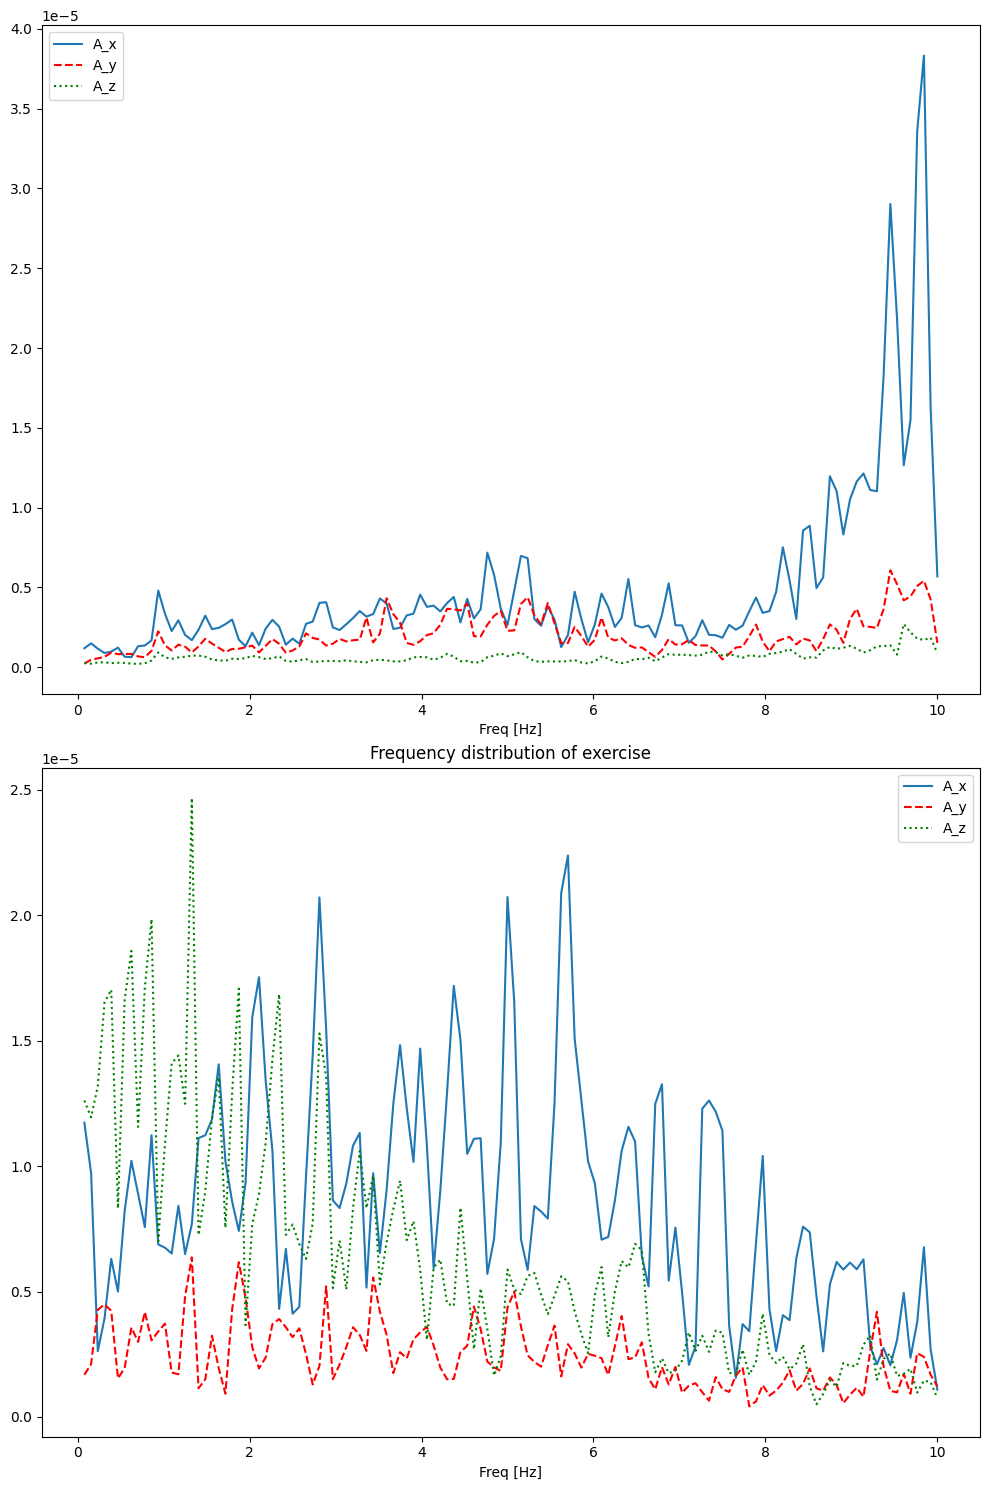

In [11]:
periodogram_plot(1,1,'LegCurl',2,1,'LegCurl', 'acc')

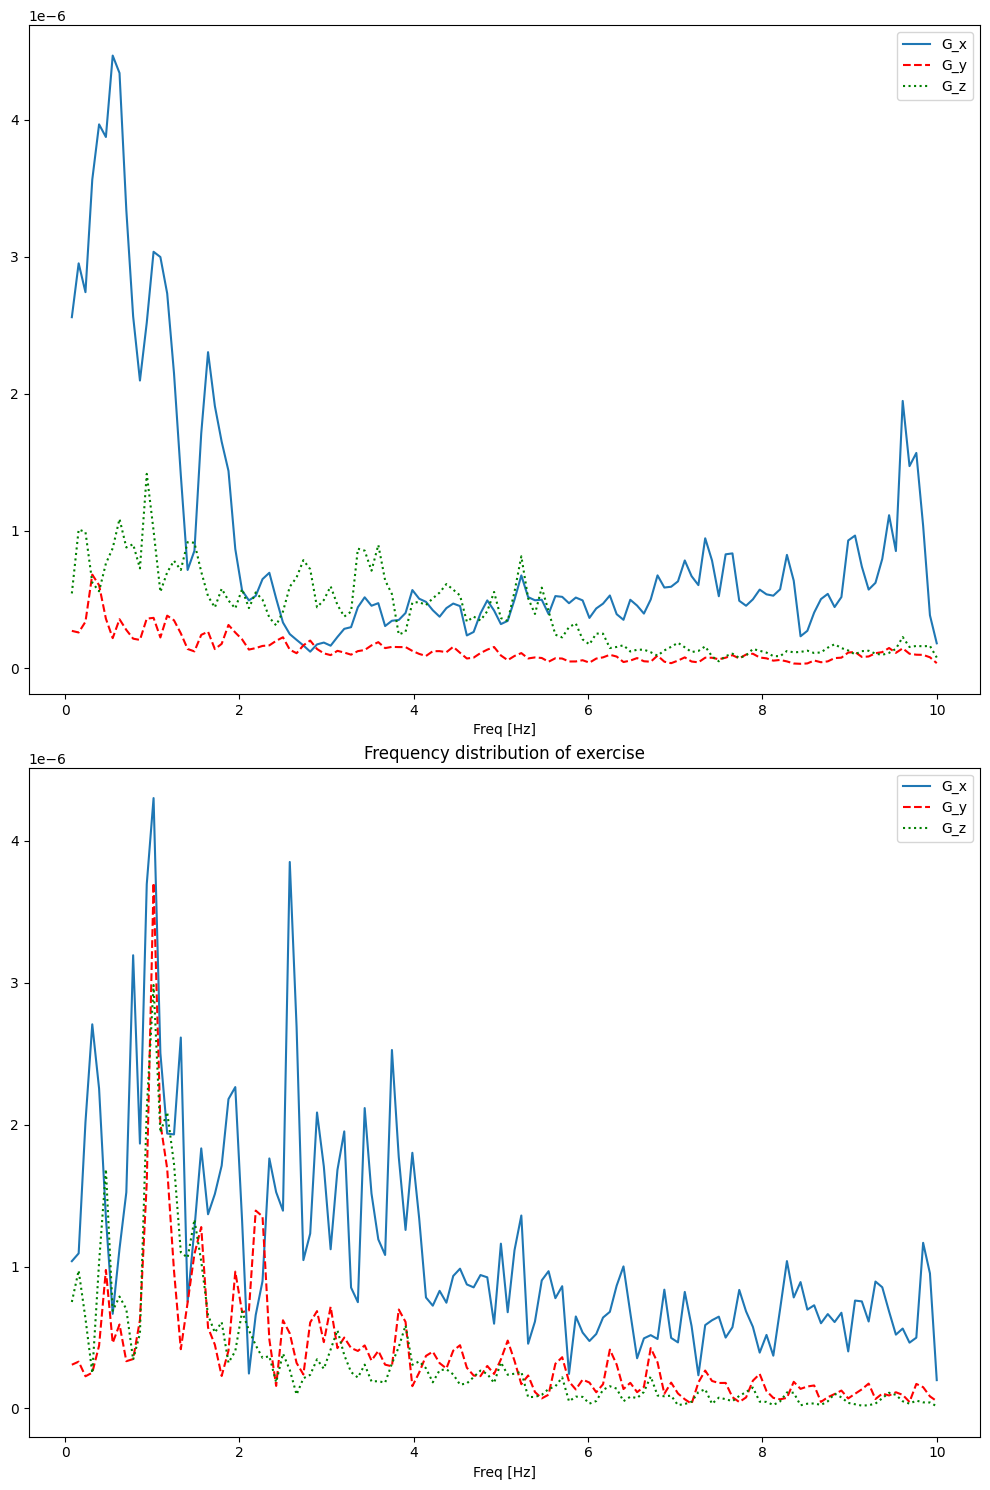

In [12]:
periodogram_plot(1,1,'LegCurl',2,1,'LegCurl', 'gyro')

Both for different subjects and different sessions periodogram share bigger similarity than spectrograms which shows that the frequency distribution plays major role in classifying the exercise type.


In [13]:
subject = 1
session = 1
workout = 'BenchPress'

exercise = lbl_gym[(lbl_gym['Subject'] == subject) & (lbl_gym['Session'] == session) 
                      & (lbl_gym['Workout'] == workout) ]

cols_to_plot = ['A_x', 'A_y', 'A_z', 'G_x', 'G_y', 'G_z', 'C_1']   


f, t, Sxx = signal.spectrogram(
            exercise[cols_to_plot[0]], 
            fs=1, 
            nperseg=256,    
            noverlap=64, 
            scaling='density'
        )
print(Sxx.shape)

(129, 26)


In [14]:
signals = []

lbl_gym = lbl_gym[lbl_gym['Position'] == 'wrist']

grouped_gym = lbl_gym.groupby(['Subject', 'Session', 'Workout'])

for subj in range(1, 11):
    for sess in range(1, 6):
        for workout in ['LegCurl', 'Squat', 'Adductor', 'LegPress', 'ArmCurl',
           'BenchPress', 'RopeSkipping', 'Walking', 'Running', 'StairClimber', 'Riding']:

            try:
                exercise = grouped_gym.get_group((subj, sess, workout))
            except:
                continue

            cols_to_plot = ['A_x', 'A_y', 'A_z', 'G_x', 'G_y', 'G_z', 'C_1'] 

            signals.append({'Ax': exercise['A_x'],
                           'Ay': exercise['A_y'],
                           'Az': exercise['A_z'],
                           'Gx': exercise['G_x'],
                            'Gy': exercise['G_y'],
                            'Gz': exercise['G_z'],
                           'C1': exercise["C_1"],
                           'Target': workout})

# Result

We can't feed in decomposed wavelets to Random Forrest because they have various lengths. However we can extract metrics from levels of components and take them to the classifier. The data is split 20/80 and reaches **~95%** accuracy.

Classification Accuracy: 0.96


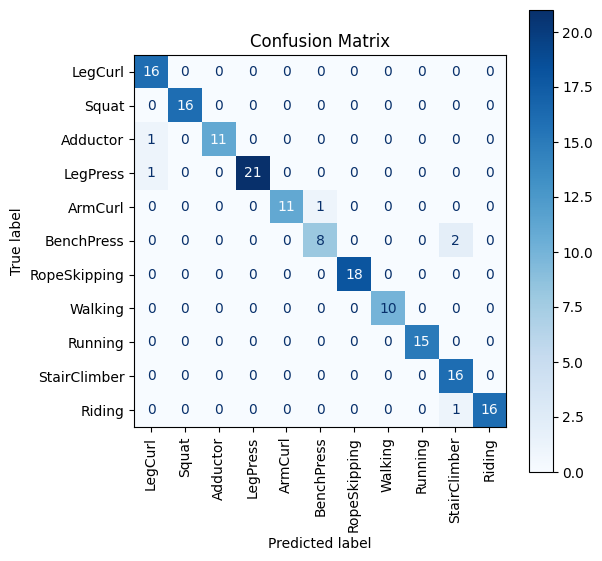

In [15]:
import numpy as np
import pandas as pd
import pywt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ---------------------------------------------------------
# 1. Helper Function: Extract Features from ONE Signal
# ---------------------------------------------------------
def calculate_entropy(x):
    """Calculate Shannon Entropy of a signal's energy distribution."""
    energy = x**2
    total_energy = np.sum(energy)
    if total_energy == 0:
        return 0
    probabilities = energy / total_energy
    # Add small epsilon to avoid log(0)
    entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))
    return entropy

def extract_wavelet_features(signal, waveletname='db4', level=4):
    """
    Decomposes a signal and calculates statistics for each sub-band.
    """
    # 1. Decompose the signal into coefficients
    # This returns a list: [Approximation_Level_N, Detail_Level_N, ..., Detail_Level_1]
    coeffsAx = pywt.wavedec(signal['Ax'], waveletname, level=level)
    coeffsAy = pywt.wavedec(signal['Ay'], waveletname, level=level)
    coeffsAz = pywt.wavedec(signal['Az'], waveletname, level=level)
    coeffsGx = pywt.wavedec(signal['Gx'], waveletname, level=level)
    coeffsGy = pywt.wavedec(signal['Gy'], waveletname, level=level)
    coeffsGz = pywt.wavedec(signal['Gz'], waveletname, level=level)
    coeffsC1 = pywt.wavedec(signal['C1'], waveletname, level=level)
    
    
    features = []
    
    # 2. Loop through each level's coefficients (sub-bands)
    for i, coeff in enumerate(coeffsAx):
        # Calculate statistics for this specific frequency band
        features.extend([
            np.mean(coeff),        # Mean
            np.std(coeff),         # Standard Deviation (spread)
            np.max(coeff),         # Max value (peak)
            np.sum(coeff**2),      # Energy (Power)
            calculate_entropy(coeff) # Entropy (Complexity)
        ])

    for i, coeff in enumerate(coeffsAy):

    # Calculate statistics for this specific frequency band
        features.extend([
            np.mean(coeff),        # Mean
            np.std(coeff),         # Standard Deviation (spread)
            np.max(coeff),         # Max value (peak)
            np.sum(coeff**2),      # Energy (Power)
            calculate_entropy(coeff) # Entropy (Complexity)
        ])

    for i, coeff in enumerate(coeffsAz):

    # Calculate statistics for this specific frequency band
        features.extend([
            np.mean(coeff),        # Mean
            np.std(coeff),         # Standard Deviation (spread)
            np.max(coeff),         # Max value (peak)
            np.sum(coeff**2),      # Energy (Power)
            calculate_entropy(coeff) # Entropy (Complexity)
        ])


    for i, coeff in enumerate(coeffsGx):

    # Calculate statistics for this specific frequency band
        features.extend([
            np.mean(coeff),        # Mean
            np.std(coeff),         # Standard Deviation (spread)
            np.max(coeff),         # Max value (peak)
            np.sum(coeff**2),      # Energy (Power)
            calculate_entropy(coeff) # Entropy (Complexity)
        ])


    for i, coeff in enumerate(coeffsGy):

    # Calculate statistics for this specific frequency band
        features.extend([
            np.mean(coeff),        # Mean
            np.std(coeff),         # Standard Deviation (spread)
            np.max(coeff),         # Max value (peak)
            np.sum(coeff**2),      # Energy (Power)
            calculate_entropy(coeff) # Entropy (Complexity)
        ])


    for i, coeff in enumerate(coeffsGz):

    # Calculate statistics for this specific frequency band
        features.extend([
            np.mean(coeff),        # Mean
            np.std(coeff),         # Standard Deviation (spread)
            np.max(coeff),         # Max value (peak)
            np.sum(coeff**2),      # Energy (Power)
            calculate_entropy(coeff)])

    for i, coeff in enumerate(coeffsC1):

    # Calculate statistics for this specific frequency band
        features.extend([
            np.mean(coeff),        # Mean
            np.std(coeff),         # Standard Deviation (spread)
            np.max(coeff),         # Max value (peak)
            np.sum(coeff**2),      # Energy (Power)
            calculate_entropy(coeff)])
    
    
    return features

# ---------------------------------------------------------
# 2. Simulate Data (Replace this with your 7 signals)
# ---------------------------------------------------------
# Let's pretend we have 100 signals (50 Class A, 50 Class B)
# Each signal is 4800 points long (4 mins @ 20Hz)
n_samples = len(signals)


# ---------------------------------------------------------
# 3. Process All Signals -> Feature Matrix
# ---------------------------------------------------------
X_features = []
for signal in signals:
    feats = extract_wavelet_features(signal, waveletname='db4', level=4)
    X_features.append(feats)

X_features = np.array(X_features)

y = []
wrk = ['LegCurl', 'Squat', 'Adductor', 'LegPress', 'ArmCurl',
           'BenchPress', 'RopeSkipping', 'Walking', 'Running', 'StairClimber', 'Riding']

for signal in signals:
    y.append(wrk.index(signal['Target']))
y = np.array(y)

# ---------------------------------------------------------
# 4. Train Random Forest
# ---------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.3)

rf = RandomForestClassifier(n_estimators=120)
rf.fit(X_train, y_train)

preds = rf.predict(X_test)
print(f"Classification Accuracy: {accuracy_score(y_test, preds):.2f}")

# 2. Compute the matrix
cm = confusion_matrix(y_test, preds)

# 3. Plot it
# 'display_labels' should match your class names (e.g., ['Normal', 'Fault'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=wrk)

# Plot with a colormap (cmap='Blues' makes it easy to read)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax)
plt.title("Confusion Matrix")
plt.xticks(rotation='vertical')
plt.show()

# Neural Network with 1DConv

In [16]:
X = []
y = []

from scipy import signal

for name, df in grouped_gym:
    subject, session, workout = name[0], name[1], name[2]

    f1, p1 = signal.welch(df['A_x'], fs=20, nperseg=64)
    f2, p2 = signal.welch(df['A_y'], fs=20, nperseg=64)
    f3, p3 = signal.welch(df['A_z'], fs=20, nperseg=64)
    f4, p4 = signal.welch(df['G_x'], fs=20, nperseg=64)
    f5, p5 = signal.welch(df['G_y'], fs=20, nperseg=64)
    f6, p6 = signal.welch(df['G_z'], fs=20, nperseg=64)
    f7, p7 = signal.welch(df['C_1'], fs=20, nperseg=64)

    pall = np.array([p1, p2, p3, p4, p5, p6, p7]).flatten()

    pmin = pall.min()
    pmax = pall.max()

    spread = pmax - pmin

    p1 = (p1 + pmin)/spread
    p2 = (p2 + pmin)/spread
    p3 = (p3 + pmin)/spread
    p4 = (p4 + pmin)/spread
    p5 = (p5 + pmin)/spread
    p6 = (p6 + pmin)/spread
    p7 = (p7 + pmin)/spread

    X.append([p1, p2, p3, p4, p5, p6, p7])
    y.append(workout)


X = np.array(X)
print(X.shape)   # (545, 7, 33)
print(y[0])      # Adductor

(545, 7, 33)
Adductor


In [17]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle

# 1. Convert lists to numpy arrays
X = np.array(X)  # Shape: (545, 7, 33)
y = np.array(y)

# 2. Transpose X for Conv1D
# We want shape: (Batch, Frequency_Bins, Sensors) -> (545, 33, 7)
# This allows the Conv1D to slide across the frequency spectrum.
X = X.transpose(0, 2, 1) 

# 3. Encode Labels (String -> Int -> OneHot)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)
num_classes = y_categorical.shape[1]



X, y_categorical = shuffle(X, y_categorical, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, 
    test_size=0.2, 
    random_state=42, 
)

X_validate, X_test, y_validate, y_test = train_test_split(
    X, y_categorical, 
    test_size=0.5, 
    random_state=42, 
)

print(f"Training Input Shape: {X_train.shape}") # Should be (N, 33, 7)
print(f"Num Classes: {num_classes}")

2025-12-27 19:23:54.561244: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766863434.772574      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766863434.831474      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766863435.328397      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766863435.328437      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766863435.328440      17 computation_placer.cc:177] computation placer alr

Training Input Shape: (436, 33, 7)
Num Classes: 11


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()


# Scans across frequencies looking for patterns in the 7 sensors
lowerConv = Conv1D(filters=32, kernel_size=8, activation='relu', input_shape=(33, 7))
model.add(lowerConv)
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2)) # Reduces dim from 33 -> 16

# Layer 2: Deep features
upperConv = Conv1D(filters=64, kernel_size=5, activation='relu')
model.add(upperConv)
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2)) # Reduces dim from 16 -> 8

# Flatten and classify
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5)) # Regularization to prevent overfitting on small data

model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-12-27 19:24:09.763594: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 26, 32)         │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 13, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 9, 64)          │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 9, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,675 (115.92 KB)

 Trainable params: 29,483 (115.17 KB)

 Non-trainable params: 192 (768.00 B)

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint

# 1. Define the callback
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',  # Save the best model to a file
    monitor='val_accuracy',       # What to track
    mode='max',                   # We want accuracy to be Max (use 'min' for loss)
    save_best_only=True,          # Only overwrite if it's better
    verbose=1
)

# Train
history = model.fit(
    X_train, y_train,
    epochs=80,
    batch_size=4,
    validation_data=(X_validate, y_validate),
    verbose=1,
    callbacks=[checkpoint]
)

model.load_weights('best_model.keras')

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Final Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1/80
105/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3190 - loss: 2.5760
Epoch 1: val_accuracy improved from -inf to 0.27574, saving model to best_model.keras
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3260 - loss: 2.5418 - val_accuracy: 0.2757 - val_loss: 2.2133
Epoch 2/80
103/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8132 - loss: 0.6702
Epoch 2: val_accuracy improved from 0.27574 to 0.38235, saving model to best_model.keras
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8147 - loss: 0.6657 - val_accuracy: 0.3824 - val_loss: 1.8929
Epoch 3/80
105/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8615 - loss: 0.4635
Epoch 3: val_accuracy improved from 0.38235 to 0.70221, saving model to best_model.keras
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8616 - loss: 0.4624 - val_accuracy: 0.7022 - val_loss: 1.2909
Epoch 4/80
107/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8841 - loss: 0.4036
Epoch 4: val_accuracy improved from 0.702

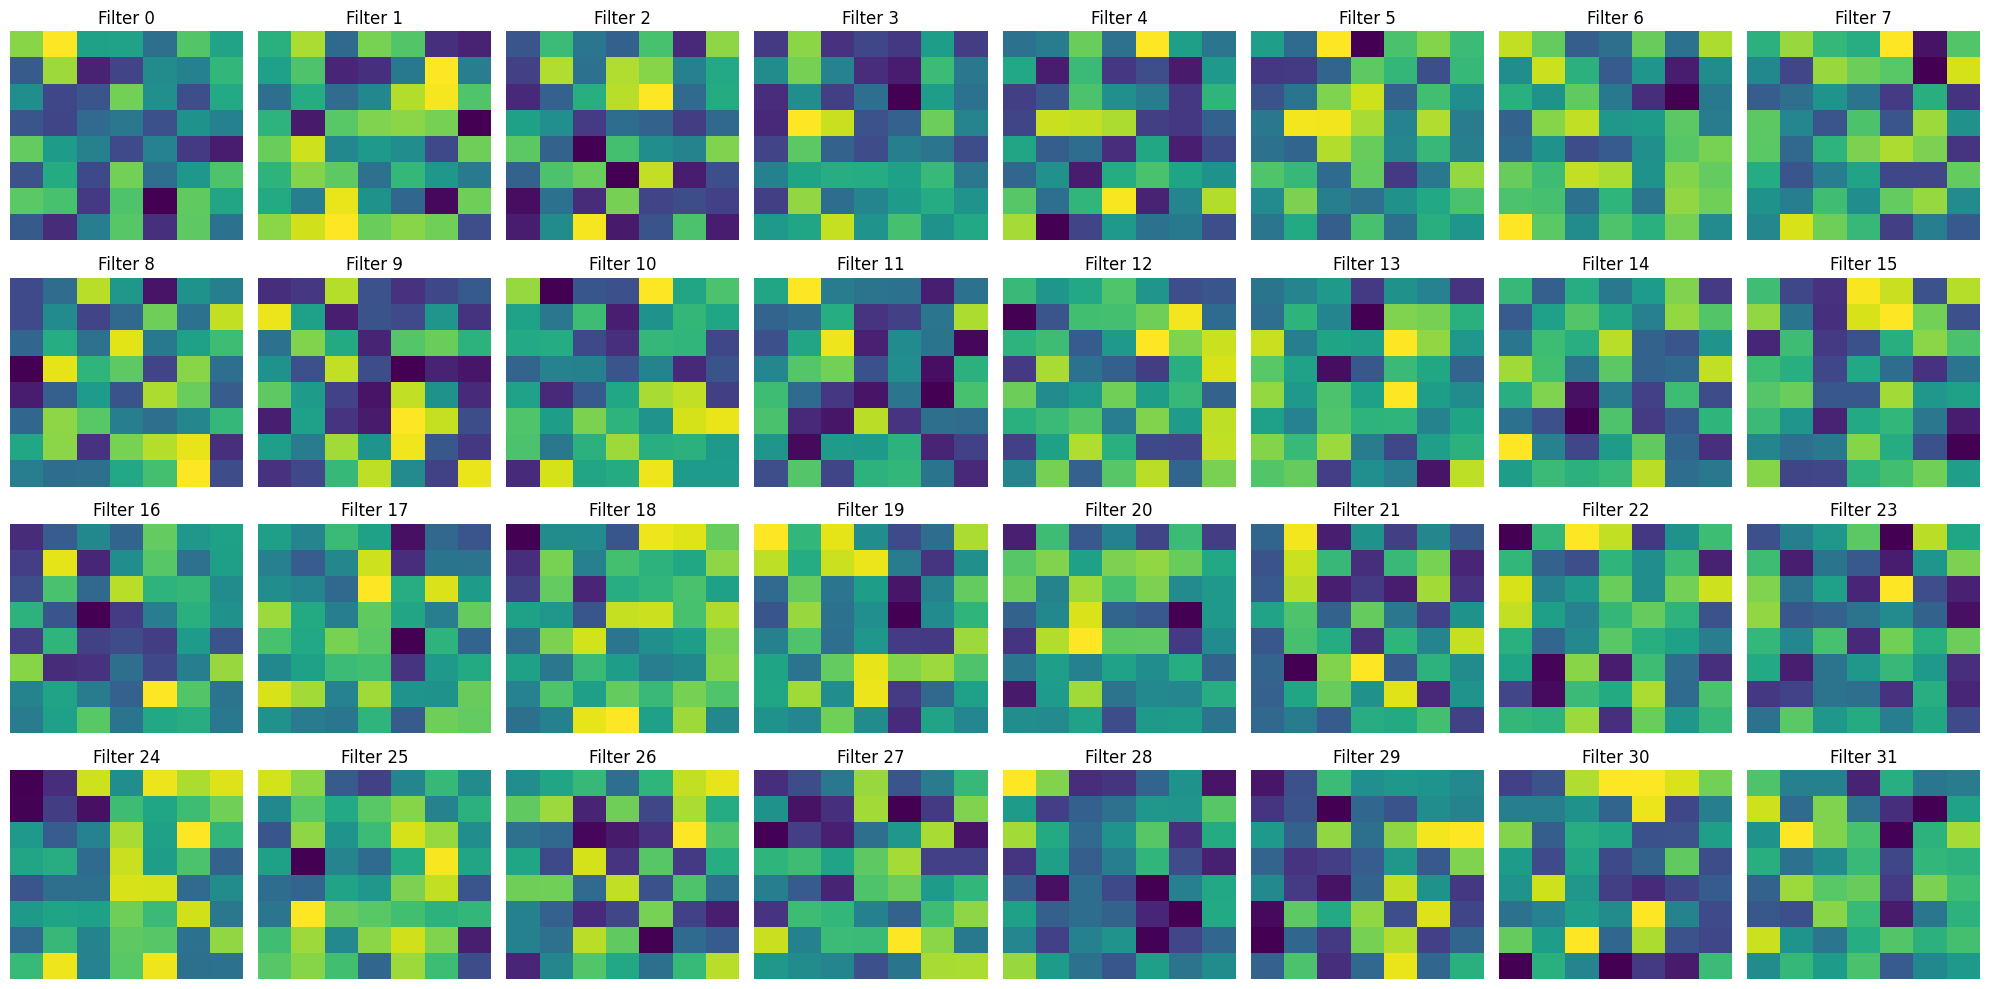

In [20]:
import seaborn as sns

weights = lowerConv.get_weights()[0]

# 2. Set up a grid to visualize each of the 32 filters
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
axes = axes.flatten()

for i in range(32):
    # Extract the i-th filter: shape will be (8, 7)
    filter_i = weights[:, :, i]
    
    sns.heatmap(filter_i, ax=axes[i], cmap='viridis', cbar=False)
    axes[i].set_title(f"Filter {i}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Fitted model shows ~ 99% accuracy performance thanks to convolution1d, pooling and feature normalization. Unfortunately patterns learned by convolution seem chaotic and we can't derive any conclusions about the frequencies relation to exercise type.

# Thanks

Further work:

* state of art recognition: Convolutional Neural Network reading spectograms
* see how much worse is FFT
* do something for Capacitance because it is confusing Random Forest
* tune hyperparameters